In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from unified_functions import *
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score

In [2]:
def train_and_evaluate_model_multiclass(model, X, y, numerical_cols, categorical_cols, n_folds,
                             tune_params=False, param_grid=None, 
                             tuning_scoring='roc_auc_ovr', tuning_test_size=0.2):

    classes = np.unique(y)
    n_classes = len(classes)

    y_pred_probs_all = []
    y_pred_all = []
    y_true_all = []

    fpr_dict = {}
    tpr_dict = {}

    if not tune_params:
        print("Training model with default hyperparameters...\n")

        cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=2)

        for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
            model_pipeline = get_model_pipeline(model, numerical_cols, categorical_cols)

            X_train_split, X_test_split = X.iloc[train_idx], X.iloc[test_idx]
            y_train_split, y_test_split = y.iloc[train_idx], y.iloc[test_idx]

            model_pipeline.fit(X_train_split, y_train_split)

            y_pred_prob_fold = model_pipeline.predict_proba(X_test_split)
            y_pred_fold = model_pipeline.predict(X_test_split)

            y_test_bin = label_binarize(y_test_split, classes=classes)

            for c in range(n_classes):
                fpr_dict.setdefault(c, [])
                tpr_dict.setdefault(c, [])
                fpr, tpr, _ = roc_curve(y_test_bin[:, c], y_pred_prob_fold[:, c])
                fpr_dict[c].append(fpr)
                tpr_dict[c].append(tpr)

            y_pred_probs_all.append(y_pred_prob_fold)
            y_pred_all.append(y_pred_fold)
            y_true_all.append(y_test_split)

            fold_auc = roc_auc_score(y_test_bin, y_pred_prob_fold, multi_class='ovr')
            print(f"Fold {i} AUC (macro-OVR): {fold_auc:.4f}")

        best_params = model.get_params()

    else:
        print("Tuning hyperparameters...\n")

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=tuning_test_size, stratify=y, random_state=42
        )

        best_params = tune_hyperparameters(
            model, param_grid, X_train, y_train,
            numerical_cols, categorical_cols, 
            n_folds=3, scoring=tuning_scoring
        )
        model.set_params(**best_params)

        model_pipeline = get_model_pipeline(model, numerical_cols, categorical_cols)
        model_pipeline.fit(X_train, y_train)

        y_pred_prob = model_pipeline.predict_proba(X_test)
        y_pred = model_pipeline.predict(X_test)

        y_pred_probs_all = [y_pred_prob]
        y_pred_all = [y_pred]
        y_true_all = [y_test]

        y_test_bin = label_binarize(y_test, classes=classes)
        for c in range(n_classes):
            fpr_dict[c], tpr_dict[c], _ = roc_curve(y_test_bin[:, c], y_pred_prob[:, c])

    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)
    y_pred_probs = np.vstack(y_pred_probs_all)

    y_true_bin = label_binarize(y_true, classes=classes)

    auc_macro = roc_auc_score(y_true_bin, y_pred_probs, multi_class='ovr', average="macro")
    auc_micro = roc_auc_score(y_true_bin, y_pred_probs, multi_class='ovr', average="micro")

    print("\nTotal scores:")
    print(f"Macro AUC: {auc_macro:.4f}")
    print(f"Micro AUC: {auc_micro:.4f}\n")

    return (
        y_true, y_pred, y_pred_probs,
        fpr_dict, tpr_dict,
        auc_macro, auc_micro,
        model_pipeline, best_params
    )


In [3]:
df = pd.read_csv("../materials/processed_df_new.csv")
df.columns
df['is_upgraded'] = (df['ISUP RP'] > df['Bx ISUP Grade']).astype(int)
# df['upgrade_diff'] = np.clip(df['ISUP RP'] - df['Bx ISUP Grade'], a_min=0, a_max=None)
df['upgrade_diff'] = df['ISUP RP'] - df['Bx ISUP Grade']
df = df.dropna(subset=['is_upgraded', 'upgrade_diff'])

# Predictions of is_upgraded

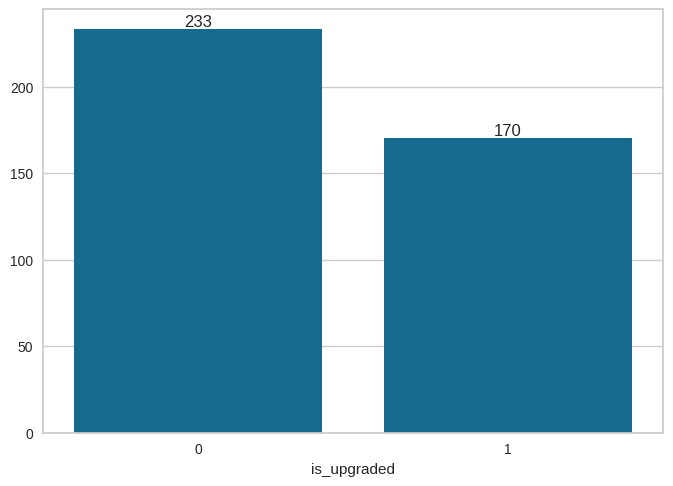

In [4]:
ax = sns.barplot(x=df['is_upgraded'].value_counts().index, y=df['is_upgraded'].value_counts().values)
ax.bar_label(ax.containers[0])
plt.show()

In [5]:
numerical_cols = ['wiek', 'PSA', 'PSAdensity', 'MRI vol', 'MRI SIZE']
categorical_cols = ['MRI Pirads', 'MRI EPE', 'MRI EPE L', 'MRI EPE P', 'MRI SVI', 'MRI SVI L', 'MRI SVI P', 'Bx ISUP Grade']

Tuning hyperparameters...



Best hyperparameters: {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Best neg_brier_score score: -0.25782660431924614

Model hyperparameters after tuning: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': 0, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 200, 'n_jobs': None, 'num_parallel_

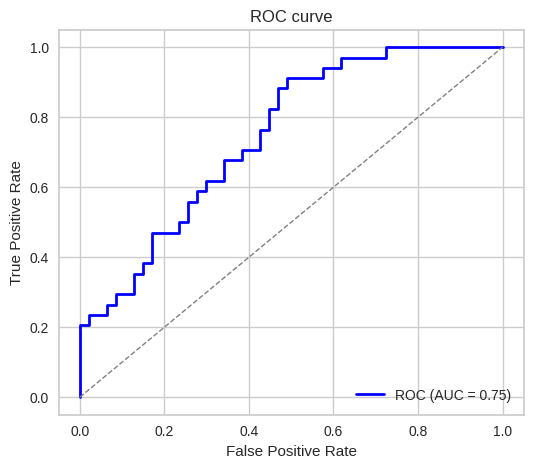

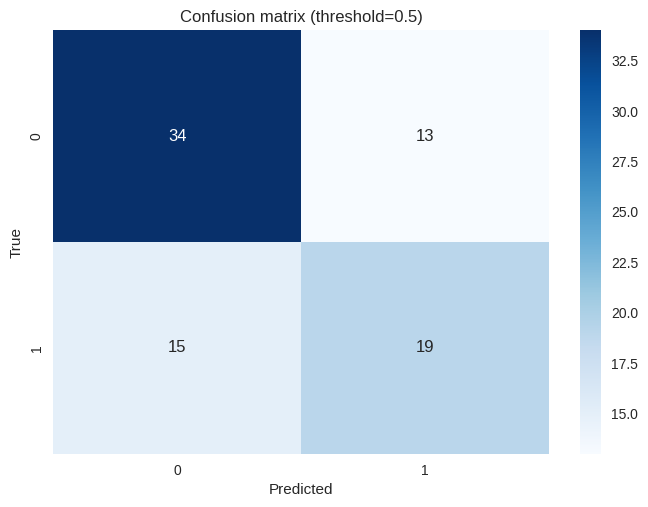

Sensitivity: 0.5588
Specificity: 0.7234
Accuracy: 0.6543%
Preparation of a new explainer is initiated

  -> data              : 404 rows 13 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 404 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7837ae27c180> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0177, mean = 0.426, max = 0.956
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.786, mean = -0.00569, max = 0.828
  -> model_info        : package sklearn

A new explainer has been created!


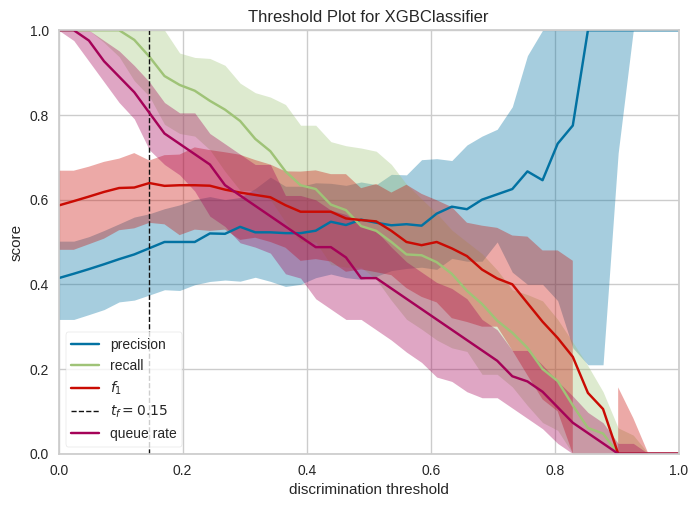

In [5]:
X = df[numerical_cols + categorical_cols]
y = df['is_upgraded']

param_grid = {
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__n_estimators': [200, 400, 800],
    'classifier__max_depth': [3, 6, 9],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.8, 0.9, 1.0],
    'classifier__gamma': [0, 0.1, 0.2]
}

model = XGBClassifier(random_state=2)

#brier score and tuning test split = 0.2
y_true, y_pred, y_pred_probs, false_positive_rate, true_positive_rate, total_roc_auc, trained_model, best_params = train_and_evaluate_model(model, X, y, numerical_cols, categorical_cols, n_folds=5, tune_params=True, param_grid=param_grid, tuning_scoring='neg_brier_score', tuning_test_size=0.2)
untrained_model = model.set_params(**best_params)

plot_roc(false_positive_rate, true_positive_rate, total_roc_auc)
plot_confusion_matrix(y_true, y_pred)
plot_feature_importances(trained_model, X, y)
plot_discrimination_threshold(untrained_model, X, y)

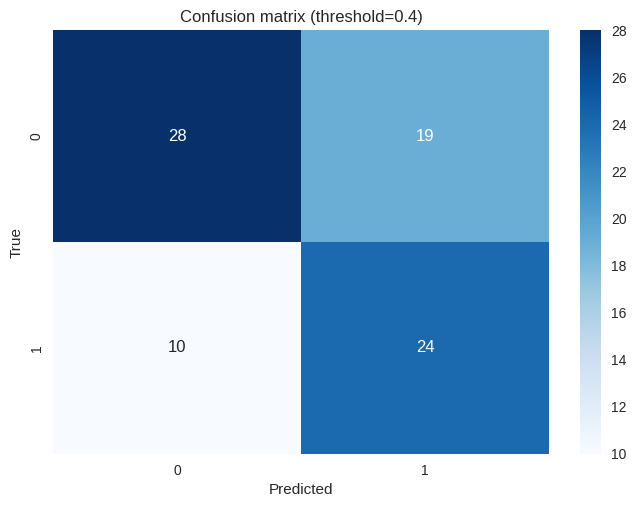

Sensitivity: 0.7059
Specificity: 0.5957
Accuracy: 0.6420%


In [9]:
plot_confusion_matrix(y_true, y_pred_probs=y_pred_probs, threshold=0.40)

# Predictions of upgrade difference

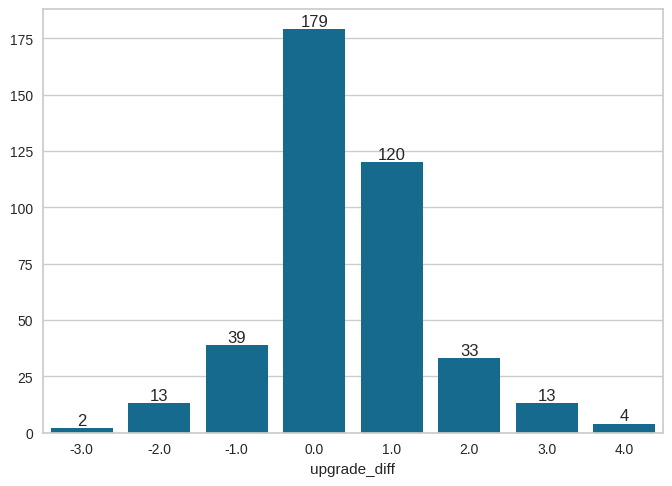

In [9]:
ax = sns.barplot(x=df['upgrade_diff'].value_counts().index, y=df['upgrade_diff'].value_counts().values)
ax.bar_label(ax.containers[0])
plt.show()

Tuning hyperparameters...



Best hyperparameters: {'classifier__colsample_bytree': 0.9, 'classifier__gamma': 0.2, 'classifier__learning_rate': 0.2, 'classifier__max_depth': 6, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Best f1_weighted score: 0.39046746036822083


Total scores:
Macro AUC: 0.6241
Micro AUC: 0.8067

Preparation of a new explainer is initiated

  -> data              : 401 rows 13 cols
  -> target variable   : 401 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x72c9b04402c0> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.000442, mean = 0.1, max = 0.928
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.118, 

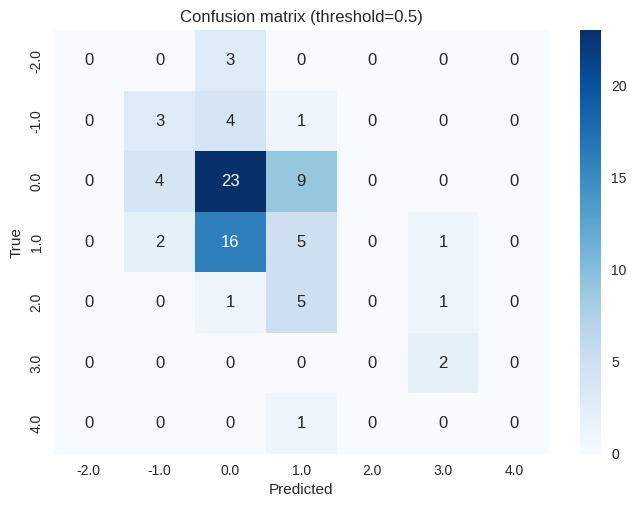

In [10]:
X = df[df['upgrade_diff'] != -3][numerical_cols + categorical_cols]
# y = LabelEncoder().fit_transform(df['upgrade_diff'])
enc = LabelEncoder()
y = enc.fit_transform(df[df['upgrade_diff'] != -3]["upgrade_diff"])

param_grid = {
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__n_estimators': [200, 400, 800],
    'classifier__max_depth': [3, 6, 9],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.8, 0.9, 1.0],
    'classifier__gamma': [0, 0.1, 0.2]
}

model = XGBClassifier(random_state=2)

y_true, y_pred, y_pred_probs, false_positive_rate, true_positive_rate, auc_macro, auc_micro, trained_model, best_params = train_and_evaluate_model_multiclass(model, X, y, numerical_cols, categorical_cols, n_folds=5, tune_params=True, param_grid=param_grid, tuning_scoring='f1_weighted', tuning_test_size=0.2)
untrained_model = model.set_params(**best_params)

plot_feature_importances(trained_model, X, y)
plot_confusion_matrix_multiclass(y_true, y_pred, label_encoder=enc)